In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

from satellite2map.datasets import Maps
from satellite2map.models.generator import UnetGenerator
from satellite2map.models.discriminator import ConditionalDiscriminator
from satellite2map.losses import GeneratorLoss, DiscriminatorLoss
import satellite2map.transforms as T

from dataclasses import dataclass
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# CycleGAN implementation

In [3]:
@dataclass
class hyperparameters:
    # training hyperparams
    n_epochs: int = 100
    batch_size: int = 32
    lr: float = 2e-3

hyperparams = hyperparameters()

In [4]:
wandb.init(
    # set the wandb project where this run will be logged
    project="satellite2map_cyclegan",

    # track hyperparameters and run metadata
    config={
    "learning_rate": hyperparams.lr,
    "architecture": "Unet",
    "dataset": "Maps",
    "epochs": hyperparams.n_epochs,
    "batch_size": hyperparams.batch_size,
    }
)

## Loading data

In [5]:
transforms = T.Compose([T.Resize((256,256)),
                        T.HorizontalFlip(0.5),
                        T.VerticalFlip(0.5),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])

train_dataset = Maps(root='../data/raw', mode='train', transform=transforms, download=False)
val_dataset   = Maps(root='../data/raw', mode='val', transform=transforms, download=False)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=hyperparams.batch_size, shuffle=True)

1 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
4 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


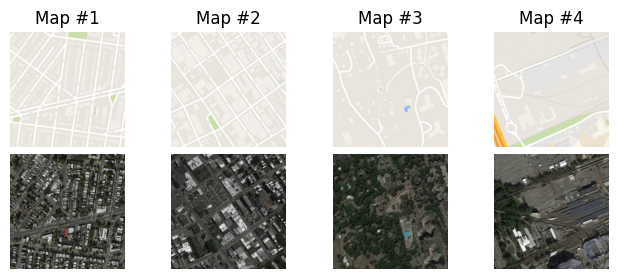

In [6]:
for i, (sat, map) in enumerate(train_dataset):
    i = i + 1
    print(i, sat.shape, map.shape)

    ax = plt.subplot(1, 4, i)
    plt.tight_layout()
    ax.set_title('Satellite #{}'.format(i))
    ax.axis('off')
    sat = sat * 0.5 + 0.5
    plt.imshow(sat.permute((1, 2, 0)).numpy())

    ax = plt.subplot(2, 4, i)
    plt.tight_layout()
    ax.set_title('Map #{}'.format(i))
    ax.axis('off')
    map = map * 0.5 + 0.5
    plt.imshow(map.permute((1, 2, 0)).numpy())

    if i == 4:
        plt.show()
        break

# Preparing for training

In [7]:
# models
generator1 = UnetGenerator().to(DEVICE)
discriminator1 = ConditionalDiscriminator().to(DEVICE)
generator2 = UnetGenerator().to(DEVICE)
discriminator2 = ConditionalDiscriminator().to(DEVICE)

# losses
g_criterion = GeneratorLoss(alpha=1, use_l1=False)
d_criterion = DiscriminatorLoss()
cc_criterion = nn.L1Loss()

# optimizers
g1_optimizer = torch.optim.Adam(generator1.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))
d1_optimizer = torch.optim.Adam(discriminator1.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))
g2_optimizer = torch.optim.Adam(generator2.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))
d2_optimizer = torch.optim.Adam(discriminator2.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))

## Training loop

In [8]:
"""
VINI REMEMBER:
gX_loss_<train|val> - generator X EPOCH loss
dX_loss_<train|val> - discriminator X EPOCH loss
gX_loss - generator X BATCH loss
dX_loss - discriminator X BATCH loss
"""

for epoch in range(hyperparams.n_epochs):
    g1_loss_train=0.
    d1_loss_train=0.
    g2_loss_train=0.
    d2_loss_train=0.
    start = time.time()
    for sat_real, map_real in tqdm(train_dataloader):
        sat_real = sat_real.to(DEVICE)
        map_real = map_real.to(DEVICE)

        # Training discriminators
        discriminator1.train()
        discriminator2.train()
        with torch.autocast(device_type=DEVICE):
            # Generating fake data
            map_fake = generator1(sat_real)
            sat_fake = generator2(map_real)

            # Discriminator 1
            fake_pred1 = discriminator1(map_fake.detach(), sat_real)
            real_pred1 = discriminator1(map_real, sat_real)
            d1_loss = d_criterion(fake_pred1, real_pred1)

            # Discriminator 2
            fake_pred2 = discriminator2(sat_fake.detach(), map_real)
            real_pred2 = discriminator2(sat_real, map_real)
            d2_loss = d_criterion(fake_pred2, real_pred2)

            # Combined loss
            d_loss = d1_loss + d2_loss

        # Discriminator`s params update
        d1_optimizer.zero_grad()
        d2_optimizer.zero_grad()
        d_loss.backward()
        d1_optimizer.step()
        d2_optimizer.step()

        # Train generators
        generator1.train()
        generator2.train()
        with torch.autocast(device_type=DEVICE):
            # Generator's loss
            fake_pred1 = discriminator1(map_fake, sat_real)
            g1_loss = g_criterion(map_fake, map_real, fake_pred1)
            fake_pred2 = discriminator2(sat_fake, map_real)
            g2_loss = g_criterion(sat_fake, sat_real, fake_pred2)

            # Cycle loss
            sat_reconstructed = generator2(map_fake)
            map_reconstructed = generator1(sat_fake)
            cycle1_loss = cc_criterion(sat_real, sat_reconstructed)
            cycle2_loss = cc_criterion(map_real, map_reconstructed)

            # Combined loss
            g_loss = g1_loss + g2_loss + cycle1_loss + cycle2_loss
        
        # Generator's params update
        g1_optimizer.zero_grad()
        g2_optimizer.zero_grad()
        g_loss.backward()
        g1_optimizer.step()
        g2_optimizer.step()

        # add batch loss to epoch loss
        g1_loss_train += g_loss.item()
        d1_loss_train += d_loss.item()
        g2_loss_train += g_loss.item()
        d2_loss_train += d_loss.item()

    # mean epoch losses
    g1_loss_train /= len(train_dataloader)
    d1_loss_train /= len(train_dataloader)
    g2_loss_train /= len(train_dataloader)
    d2_loss_train /= len(train_dataloader)

    # count timeframe
    end = time.time()
    tm = (end - start)

    # validation
    generator1.eval()
    generator2.eval()
    discriminator1.eval()
    discriminator2.eval()
    g1_loss_val=0.
    d1_loss_val=0.
    g2_loss_val=0.
    d2_loss_val=0.
    tqdm.write('Validation')
    for sat_real, map_real in tqdm(val_dataloader):
        sat_real = sat_real.to(DEVICE)
        map_real = map_real.to(DEVICE)

        with torch.no_grad():
            # Generator's loss
            map_fake = generator1(sat_real)
            sat_fake = generator2(map_real)
            fake_pred1 = discriminator1(map_fake, sat_real)
            fake_pred2 = discriminator2(sat_fake, map_real)
            g1_loss = g_criterion(map_fake, map_real, fake_pred1)
            g2_loss = g_criterion(sat_fake, sat_real, fake_pred2)

            # Discriminator`s loss
            real_pred1 = discriminator1(map_real, sat_real)
            real_pred2 = discriminator2(sat_real, map_real)
            d1_loss = d_criterion(fake_pred1, real_pred1)
            d2_loss = d_criterion(fake_pred2, real_pred2)

        # add batch loss to epoch loss
        g1_loss_val += g1_loss.item()
        d1_loss_val += d1_loss.item()
        g2_loss_val += g2_loss.item()
        d2_loss_val += d2_loss.item()
    
    # mean epoch losses
    g1_loss_val /= len(val_dataloader)
    d1_loss_val /= len(val_dataloader)
    g2_loss_val /= len(val_dataloader)
    d2_loss_val /= len(val_dataloader)

    # logging
    # wandb.log({
    #     "g1_train_loss": g1_loss_train, 
    #     "d1_train_loss": d1_loss_train,
    #     "g2_train_loss": g2_loss_train,
    #     "d2_train_loss": d2_loss_train,
    #     "g1_val_loss":   g1_loss_val, 
    #     "d1_val_loss":   d1_loss_val,
    #     "g2_val_loss":   g2_loss_val,
    #     "d2_val_loss":   d2_loss_val,
    #     })
    print(f"[Epoch {epoch+1}/{hyperparams.n_epochs}]")
    print(f"Train: [G1 loss: {g1_loss_train}] [D1 loss: {d1_loss_train}] [G2 loss: {g2_loss_train}] [D2 loss: {d2_loss_train}] ETA: {tm}")
    print(f"Val: [G1 loss: {g1_loss_val}] [D1 loss: {d1_loss_val}] [G2 loss: {g2_loss_val}] [D2 loss: {d2_loss_val}]")

    if epoch % 10!=0:
        continue

    # saving the model every 10 epochs
    torch.save({
        'g1_weights': generator1.state_dict(), 
        'd1_weights': discriminator1.state_dict(), 
        'g2_weights': generator2.state_dict(),
        'd2_weights': discriminator2.state_dict()},
        f'../models/cyclegan/checkpoints/checkpoint_{epoch}.pth')

    # visualizing the results
    fig = plt.figure(figsize=(10, 10))
    random_batch = val_dataloader[torch.randint(0, len(val_dataloader), 4)]
    for i, (sat, map) in enumerate(random_batch):
        i = i + 1
        gen_map = generator1(sat.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
        gen_sat = generator2(map.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

        ax = fig.add_subplot(3, 4, i)
        ax.set_title('Satellite #{}'.format(i))
        ax.axis('off')
        sat = sat * 0.5 + 0.5
        plt.imshow(sat.permute((1, 2, 0)).numpy())

        ax = fig.add_subplot(3, 4, i+4)
        ax.set_title('Map #{}'.format(i))
        ax.axis('off')
        print(f'maps: {map.max()}, {map.min()}')
        map = map * 0.5 + 0.5
        plt.imshow(map.permute((1, 2, 0)).numpy())

        ax = fig.add_subplot(3, 4, i+8)
        ax.set_title('Generated map #{}'.format(i))
        ax.axis('off')
        gen_map = gen_map * 0.5 + 0.5
        plt.imshow(gen_map.permute((1, 2, 0)).cpu().detach().numpy())

        ax = fig.add_subplot(3, 4, i+8)
        ax.set_title('Generated sattelite #{}'.format(i))
        ax.axis('off')
        gen_sat = gen_sat * 0.5 + 0.5
        plt.imshow(gen_map.permute((1, 2, 0)).cpu().detach().numpy())

        if i == 4:
            fig.suptitle(f'Epoch {epoch+1}')
            fig.tight_layout()
            fig.subplots_adjust(top=0.88)
            plt.show()
            break

  3%|▎         | 1/35 [01:23<47:02, 83.02s/it]